# Generic examples

## Plot examples

The `plot` function is a convenient interface to `matplotlib.pyplot`, internally calling a large variety of functions, depending on the arguments (e.g., `plt.title`, `plt.legend`, `plt.colorbar`, `plt.figure`, ...)

The `plot_multiple` is an interface to the `plt.subplot` function, internally calling the `plot` function on every individual data (e.g., `kwargs`) on different subplots (if `use_subplots = True`). 

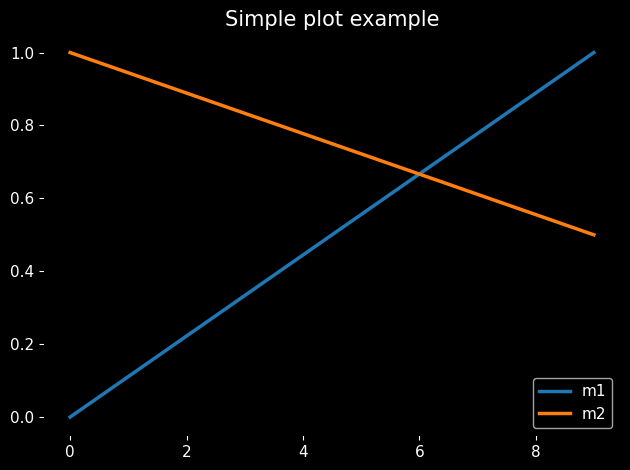

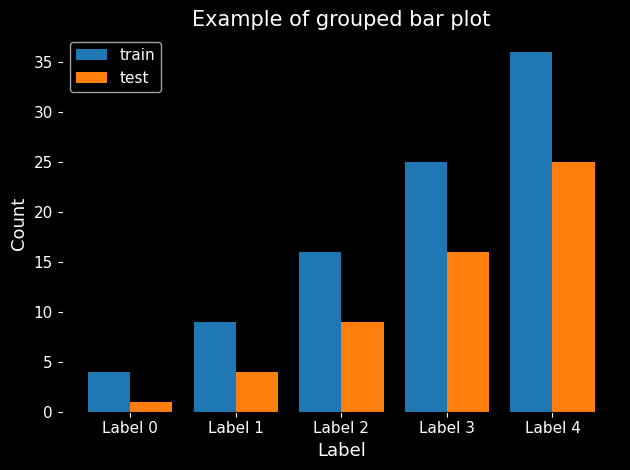

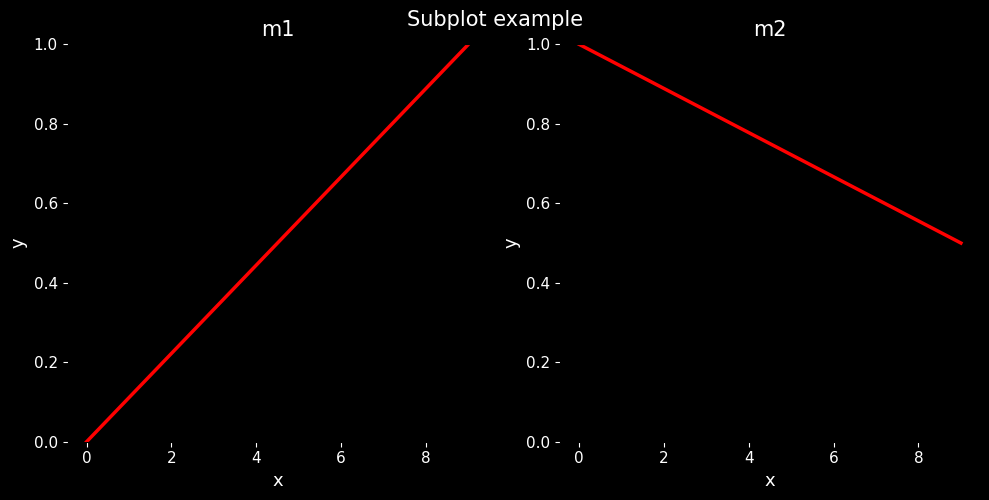

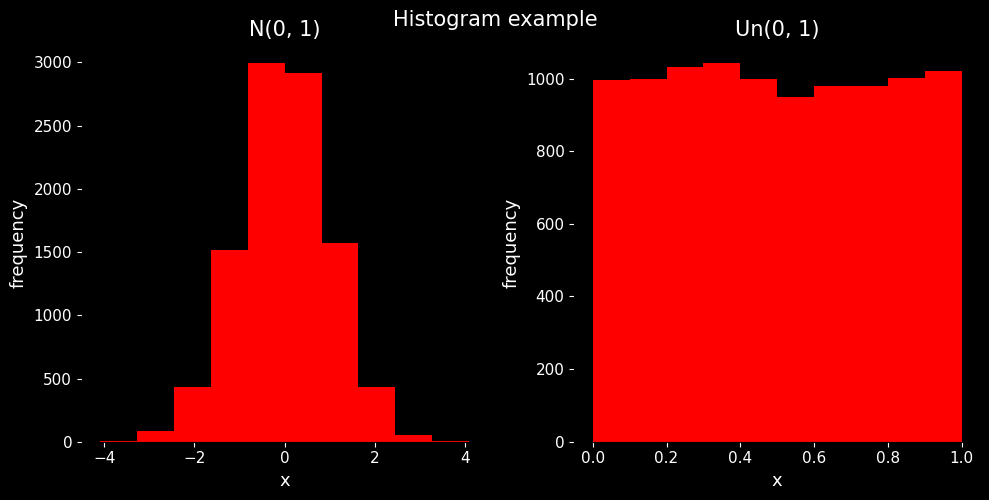

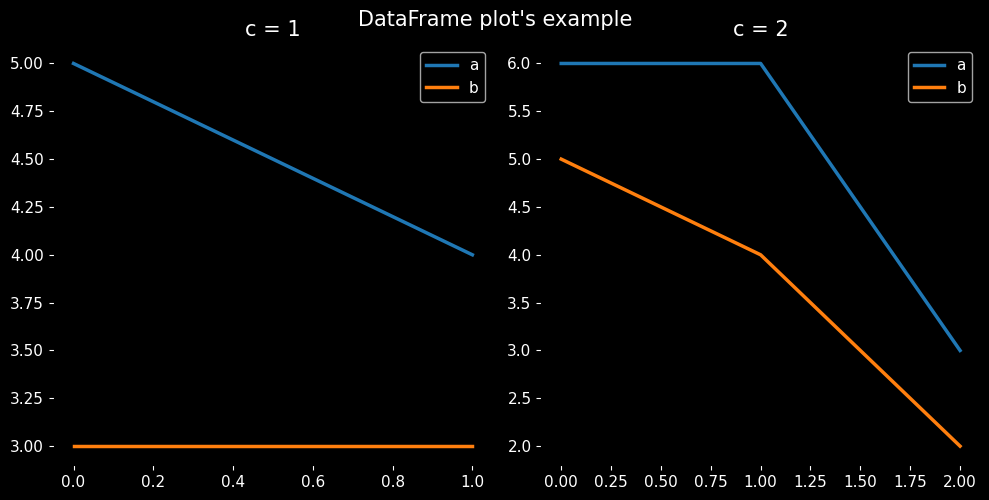

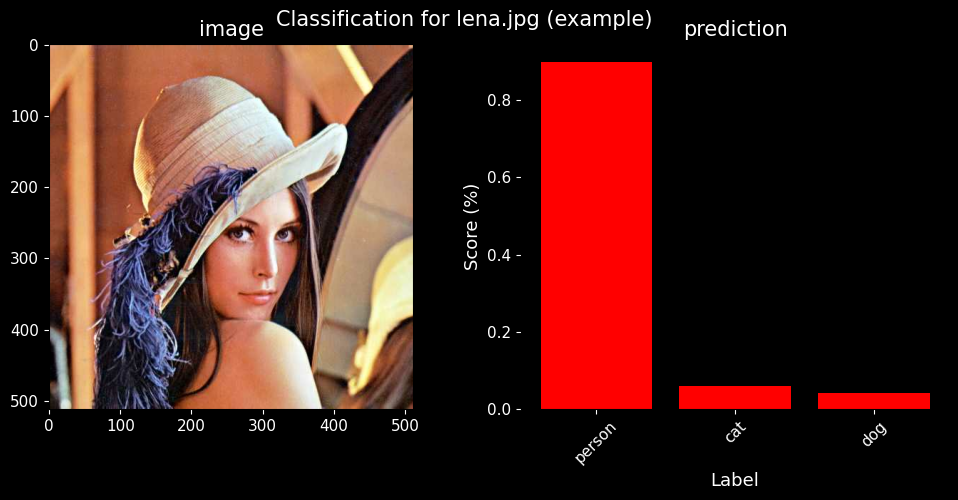

In [6]:
import os
import numpy as np
import pandas as pd

from utils import plot, plot_multiple, load_json
from utils.image import load_image

datas = {
    'm1' : np.linspace(0, 1, 10),
    'm2' : np.linspace(1, 0.5, 10)
}
random_datas = {
    'N(0, 1)'  : np.random.normal(size = 10000),
    'Un(0, 1)' : np.random.uniform(size = 10000)
}

labels_repartition = {
    'Label {}'.format(i) : {'train' : (i + 2) ** 2, 'test' : (i + 1) ** 2}
    for i in range(5)
}

dataframe = pd.DataFrame([
    {'a' : 5, 'b' : 3, 'c' : 1},
    {'a' : 4, 'b' : 3, 'c' : 1},
    {'a' : 6, 'b' : 5, 'c' : 2},
    {'a' : 6, 'b' : 4, 'c' : 2},
    {'a' : 3, 'b' : 2, 'c' : 2},
])

_default_kwargs = {'use_subplots' : True, 'horizontal' : True, 'show' : True}

plot(datas, title = 'Simple plot example')
plot(labels_repartition, plot_type = 'bar', title = 'Example of grouped bar plot', xlabel = 'Label', ylabel = 'Count')
plot_multiple(
    ** datas, title = 'Subplot example', xlabel = 'x', ylabel = 'y', ylim = (0,1),
    ** _default_kwargs, filename = 'example_data/plots/plot_simple_example.png'
)
plot_multiple(
    ** random_datas, title = 'Histogram example', xlabel = 'x', ylabel = 'frequency',
    ** _default_kwargs, plot_type = 'hist', filename = 'example_data/plots/plot_hist_example.png'
)
plot_multiple(
    dataframe, by = 'c', title = "DataFrame plot's example",
    ** _default_kwargs, filename = 'example_data/plots/plot_dataframe_example.png'
)
plot_multiple(
    dataframe, corr = 'c', title = "DataFrame correlation plot's example",
    filename = 'example_data/plots/plot_dataframe_corr_example.png'
)
# the `plot_type = imshow` automatically sets `use_subplots = True` so you must put one of those 2 kwarg 
# otherwise it will plot both (image and bar plot) in the same subplot which is useless ;)
# Note that in real model's prediction, scores are not sorted and there are much more than 3 labels.
# In this case, it will show the `k` (default 5) best scores and sort them in decreasing order
plot_multiple(
    image = load_image('example_data/images/lena.jpg'), title = 'Classification for lena.jpg (example)',
    prediction = {'scores' : np.array([0.9, 0.06, 0.04]), 'labels' : ['person', 'cat', 'dog'], 'plot_type' : 'classification'},
    filename = 'example_data/plots/plot_image_classification.png', show = True, plot_type = 'imshow'
)

## Embeddings examples

Note : the provided embeddings are samples from the VoxForge dataset embedded by my `AudioSiamese` model : `audio_siamese_256_mel_lstm` (released in [this project](https://github.com/yui-mhcp/siamese_networks))

In this plot, each dot corresponds to an audio and the colors correspond to a specific speaker (its corresponding `id` is shown in the 1st plot's legend). 

It is normal that plots are different as the `embeddings` are vectors with 256 dimensions. To project them in the 2D space, I use by default the `UMAP` projection (with the `umap` library) which is based on randomness. 

Original embeddings :
                                              filename                                          embedding  \
0    /storage/VoxForge/fr/samuelbuffet-20090703-udq...  [-0.00011343794, -0.00012576704, 0.0004697689,...   
1    /storage/VoxForge/fr/samuelbuffet-20090703-udq...  [-0.00029487943, -0.00019367959, 0.0008462651,...   
2    /storage/VoxForge/fr/samuelbuffet-20090703-udq...  [-0.00012839596, -1.3334279e-05, 0.001058621, ...   
3    /storage/VoxForge/fr/samuelbuffet-20090703-udq...  [-0.00031986443, -0.00041395996, 0.000898958, ...   
4    /storage/VoxForge/fr/samuelbuffet-20090703-udq...  [-0.00027184433, -0.00063498016, 0.00038204438...   
..                                                 ...                                                ...   
595  /storage/VoxForge/fr/anonymous-20140418-dlc/wa...  [-0.00026001988, -0.00031830306, 0.0022616049,...   
596  /storage/VoxForge/fr/anonymous-20140418-dlc/wa...  [-0.00016911788, 2.0112968e-05, 0.0007426249, ... 

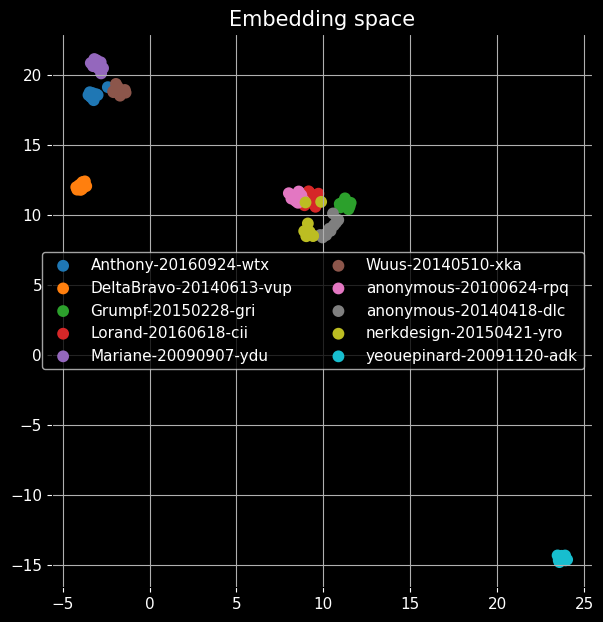

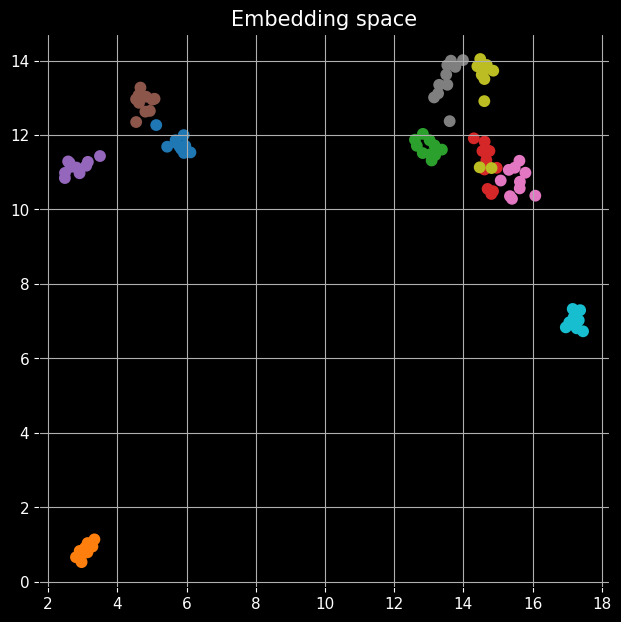

In [2]:
from utils import plot_embedding, set_display_options
from utils.embeddings import load_embeddings
from utils.pandas_utils import sample_df, aggregate_df

from loggers import set_level

set_display_options(rows = 10, width = 125)

directory = 'example_data/embeddings'
filename  = 'embeddings_256_voxforge.csv'

embeddings = load_embeddings(os.path.join(directory, filename))

print("Original embeddings :")
print(embeddings)

print("Count for each id")
print(aggregate_df(embeddings, 'id', 'filename', count = len))

samples = sample_df(embeddings) # get 10 embeddings for 10 different speakers

print("Samples to plot :")
print(samples)

plot_embedding(samples, filename = 'example_data/plots/plot_embeddings_with_legend.png')
# The legend is quite large and not really useful so you can remove it with the `with_legend` argument
plot_embedding(samples, filename = 'example_data/plots/plot_embeddings.png', with_legend = False)

## Logging example

### Timer usage

The `timer` decorater tracks the time duration of the decorated function. 

In the example below, `example_timed` is a decorated function calling 2 times `make_something_short` and 1 time `make_something_long` : 
- Each line (after `timers :`) is the time of a specific timer
- The indentation level represents the call orders (when functions are called inside another function). 
- If a function is called multiple times, performances are logged for each call, and then averaged.

The `with time_logger.timer` is a convenient feature to log some specific part of a function.

Note : `time.sleep` waits for *at least* `t` seconds, explaining why the total time is larger than 2.8sec (the expected time). It is **not** the `timer` that slows down that much the execution time ;)

In [7]:
import time

from loggers import Timer, set_level, timer

@timer
def make_something_short(t):
    time.sleep(t / 5)
    
@timer
def make_something_long(t):
    time.sleep(t)

@timer
def example_timed(t):
    make_something_short(t)
    make_something_long(t)
    for i in range(2):
        with Timer('loop iteration'): # the old `with time_logger.timer(...)` is still working
            time.sleep(0.1)
    
    print("Hello world !")

set_level('time')

example_timed(2)

Hello world !
Timers :
- example_timed : 2.603 sec
  - make_something_short : 400 ms
  - make_something_long : 2.002 sec
  - loop iteration executed 2 times : 200 ms (100 ms / exec)


### Telegram Logger

This logger sends all logs to your `Telegram` account (via the [Telegram Bot API](https://core.telegram.org/bots)).

1. Put your `Bot token` in the `TOKEN` variable
2. Send a regular message (not a command) to your bot to initialize `chat_id` (or put it manually as `kwargs`).

This logger can be useful when running codes on servers ! ;)

In [4]:
import logging

from loggers import set_level, add_handler

TOKEN = ''

set_level('info')

if TOKEN: add_handler('telegram', token = TOKEN)

logging.info('Hello World !')
logging.debug('This is a logging message (not sent)')

Hello World !


## Other examples

`load_json` and `dump_json` are utilities functions to load / save json data, while `{save / load}_data` are generic functions supporting multiple data types / file extensions.

These functions are recommanded for the following reasons : 
1. Make in 1 line a 3-line code :D
2. Avoid errors in loading / saving data, which can lead to a data destruction

Indeed, if your json file is not well formatted, having a `JsonParserError` while loading the file can destroy the file. The 2 functions converts data to `json` format before / after saving / loading them, to not have the error when the file is open. Furthermore, the `dump_json` internally calls a custom `to_json` function, that converts multiple types of data (`Tensor`, `np.ndarray`, ...) to json-serializable

In [5]:
from utils import load_data, load_json

filename = 'example_data/stft_config.json'
config = load_json(filename)
# load_data is a more general function that internally calls load_json as the extension is `.json`
print('Equivalent to load_data : {}'.format(config == load_data(filename)))
config

Equivalent to load_data : True


{'class_name': 'TacotronSTFT',
 'filter_length': 1024,
 'hop_length': 256,
 'win_length': 1024,
 'n_mel_channels': 80,
 'sampling_rate': 22050,
 'mel_fmin': 0.0,
 'mel_fmax': 8000.0,
 'normalize_mode': None,
 'pre_emph': 0.0,
 'window': 'hann',
 'to_magnitude': True,
 'periodic': True}